# 06.03 - PCA, NMF IN PRACTICE

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Reducción de dimensionalidad para tareas de clasificación

In [2]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
d=mnist[:,1:785]
c=mnist[:,0]
print ("dimension de las imagenes y las clases", d.shape, c.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


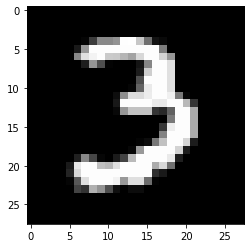

In [3]:
plt.imshow(d[9].reshape(28,28), cmap=plt.cm.gray)


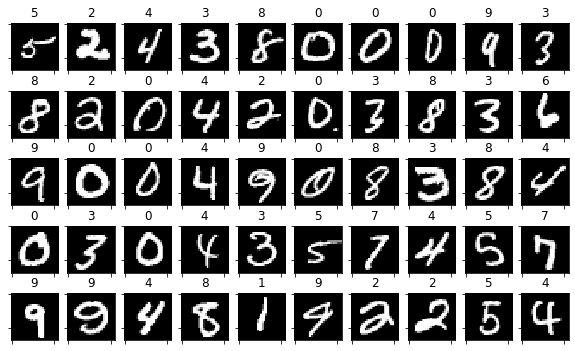

In [4]:
perm = np.random.permutation(range(d.shape[0]))[0:50]
random_imgs   = d[perm]
random_labels = c[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Principal Component Analysis

In [34]:
from sklearn.decomposition import PCA

mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]
y=mnist[:,0]

pca = PCA(n_components=10)
Xp = pca.fit_transform(X)


In [35]:
X.shape, Xp.shape

((1500, 784), (1500, 10))

In [11]:
for i in np.unique(y):
    print (i, np.sum(y==i))

0 150
1 157
2 186
3 125
4 151
5 138
6 152
7 154
8 141
9 146


In [12]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=.3)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((1050, 784), (450, 784), (1050,), (450,))

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
dt = GaussianNB()
dt.fit(Xtr, ytr)
dt.score(Xtr, ytr), dt.score(Xts, yts)

(0.72, 0.6177777777777778)

In [14]:
cs = range(10,200,5)

In [15]:
dtr, dts = [], []
for n_components in cs:
    print (".", end="")
    pca = PCA(n_components=n_components)
    pca.fit(Xtr)

    Xt_tr = pca.transform(Xtr)
    Xt_ts = pca.transform(Xts)

    dt.fit(Xt_tr,ytr)
    ypreds_tr = dt.predict(Xt_tr)
    ypreds_ts = dt.predict(Xt_ts)
    ypreds_tr.shape, ypreds_ts.shape
    dtr.append(np.mean(ytr==ypreds_tr))
    dts.append(np.mean(yts==ypreds_ts))


......................................

In [16]:
len(dtr), len(dts)

(38, 38)

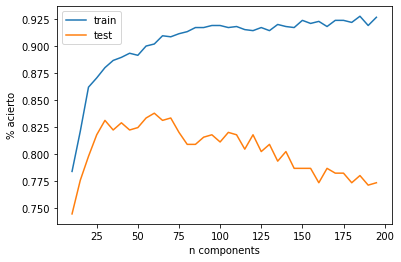

In [17]:
plt.plot(cs, dtr, label="train")
plt.plot(cs, dts, label="test")
plt.xlabel("n components")
plt.ylabel("% acierto")
plt.legend()

In [18]:
best_cs = cs[np.argmax(dts)]
best_cs

60

### clasificación en el nuevo espacio de representación

In [19]:
pca = PCA(n_components=best_cs)
pca.fit(Xtr)

Xt_tr = pca.transform(Xtr)
Xt_ts = pca.transform(Xts)
dt.fit(Xt_tr,ytr)
ypreds_tr = dt.predict(Xt_tr)
ypreds_ts = dt.predict(Xt_ts)
ypreds_tr.shape, ypreds_ts.shape
np.mean(ytr==ypreds_tr),np.mean(yts==ypreds_ts)

(0.9047619047619048, 0.8355555555555556)

### pipelines

debemos de tener cuidado cuando usamos transformaciones en clasificación, ya que tenemos que ajustarlas (de manera no supervisada) sólo con los datos de entrenamiento


In [20]:
from sklearn.pipeline import Pipeline

estimator = Pipeline((("pca", PCA(n_components=best_cs)), ("naive", dt)))
estimator.fit(Xtr, ytr)
estimator.score(Xtr, ytr), estimator.score(Xts, yts)

(0.9057142857142857, 0.8333333333333334)

In [21]:
from sklearn.model_selection import cross_val_score
pip = Pipeline([("PCA", PCA(n_components=best_cs)), ("gaussian", GaussianNB())])
scores = cross_val_score(pip, X,y, cv=5 )
print ("%.2f +/- %.4f"%(np.mean(scores), np.std(scores)))

0.84 +/- 0.0168


### obtenemos los componentes principales

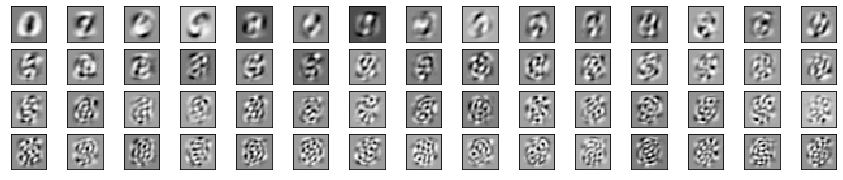

In [22]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(pca.components_)):
    plt.subplot(np.ceil(len(pca.components_)/15.),15,i+1)
    plt.imshow((pca.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### verificamos la reconstrucción con los componentes principales

In [23]:
pca = PCA(n_components=best_cs)
pca.fit(Xtr)
Xp = pca.transform(X)

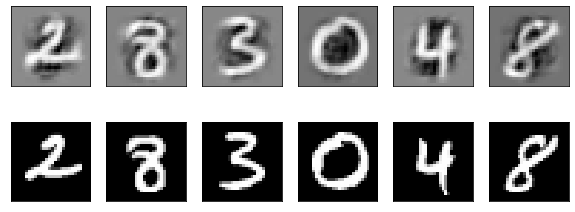

In [24]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow((np.sum((pca.components_*Xp[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### observa la nueva representación de la primera imagen

In [25]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [26]:
Xp[0]

array([-602.96544279,  709.91417575,   48.46393261,  -94.3578192 ,
       -247.5969329 , -429.06089585, -197.60517121,  531.22635527,
        439.83674877, -143.65598588, -350.95470187,  172.60373135,
       -172.73696352, -281.72027853, -126.34179342,  161.73658414,
        -81.78527347, -413.79147679,   47.59742414, -237.42715084,
        223.18870607, -258.81025144,   43.07849287, -144.98480884,
        -56.84875879,   15.95569482,  -37.29026752, -169.61029386,
        290.04985091,  -18.09769242, -156.47270457,  115.19250934,
        -92.38887583,   97.42047216, -165.2477172 ,  195.55535288,
        202.84586027,   19.77436206, -103.13657262, -196.06966884,
        124.32311744,   31.23761748,  -38.67664165,   35.31148678,
         70.87604485,  186.20659945, -128.96485438,   66.94065907,
       -149.08882182,  -46.65103309,   -4.09849795,  111.30817383,
        -52.76418032,  -40.0893952 ,  -70.94692439, -105.78083452,
        -23.79724802,  152.12095565,   59.00594154,    7.56383

which correspond to the same components above for PCA.

## Non negative matrix factorization

Descomponemos una matriz $V \in \mathbb{R}_+^{m\times n}$ en el producto $W \times H$, con $W \in \mathbb{R}_+^{m\times r}$ y $H \in \mathbb{R}_+^{r\times n}$ con la restricción de que todo sea positivo ($\in \mathbb{R}_+$), de forma que:

$$V \approx W \times H$$

Las filas de $H$ son los _componentes base_, y se soluciona planteándolo como un problema de optimización matemática con restricciones.

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H||\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

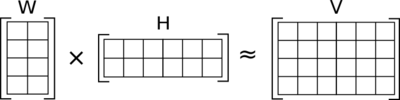

In [27]:
from IPython.display import Image
Image(filename='local/imgs/nmf.png')

### obtenemos la descomposición

In [28]:
from sklearn.decomposition import NMF
X=mnist[:,1:785]; y=mnist[:,0]

nmf = NMF(n_components=15, init="random")
Xn  = nmf.fit_transform(X)

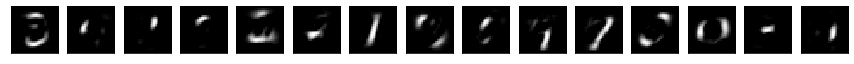

In [29]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(nmf.components_)):
    plt.subplot(len(nmf.components_)/15,15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

In [30]:
Xn[0,:]

array([0.        , 0.        , 4.95514551, 0.        , 0.        ,
       6.08083653, 1.91867923, 0.09777909, 0.        , 0.        ,
       0.        , 8.73915575, 0.        , 3.50861945, 0.        ])

### verfiicamos la reconstrucción

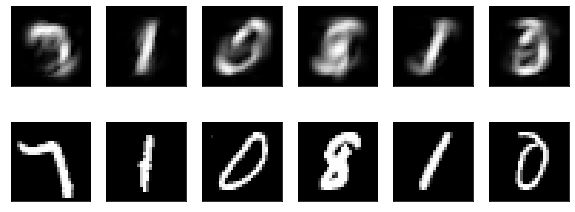

In [31]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(np.abs(np.sum((nmf.components_*Xn[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### clasificamos en el nuevo espacio de representación

In [32]:
print (np.mean(cross_val_score(GaussianNB(), X,y, cv=5 )))
print (np.mean(cross_val_score(GaussianNB(), Xn,y, cv=5 )))

0.5953333333333334
0.7733333333333333


### la primera imagen en el nuevo espacio de representación
observa que todos los componentes son positivos

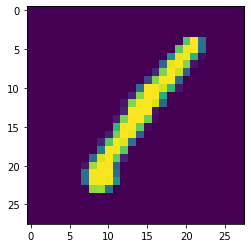

In [33]:
plt.imshow(X[0].reshape(28,28))

In [34]:
Xn[0]

array([0.        , 0.        , 4.95514551, 0.        , 0.        ,
       6.08083653, 1.91867923, 0.09777909, 0.        , 0.        ,
       0.        , 8.73915575, 0.        , 3.50861945, 0.        ])

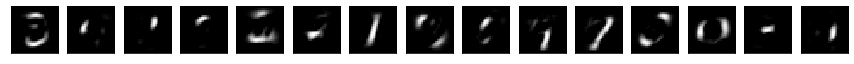

In [35]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(nmf.components_)):
    plt.subplot(len(nmf.components_)/15,15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

## NMF para el reconocimiento de rostros

In [36]:
import numpy as np
faces = np.load("local/data/faces.npy")

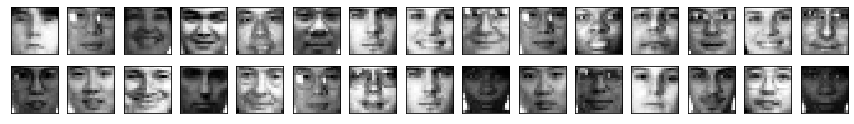

In [37]:
plt.figure(figsize=(15,2))
for i in range(30):
    plt.subplot(2,15,i+1)
    plt.imshow(faces[np.random.randint(len(faces))].reshape(19,19), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

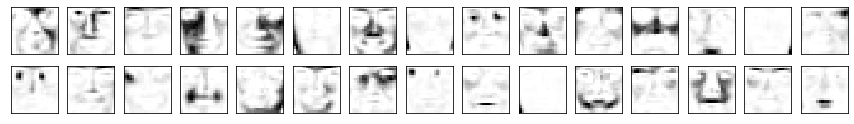

In [38]:
nmf      = NMF(n_components=30, init="random")
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
for i in range(len(nmf.components_)):
    plt.subplot(np.ceil(len(nmf.components_)/15.),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])

forzamos dispersión en los componentes, y extendemos el problema de optimización con la norma $L_1$ en los componentes base.

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||H||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

también podríamos forzar dispersión en la nueva representación
$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||W||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$


14650.57060382788


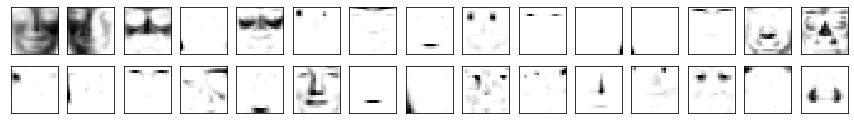

In [40]:
nmf      = NMF(n_components=30, init="nndsvd", alpha=1000, l1_ratio=1)
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
print (np.sum(nmf.components_))
for i in range(len(nmf.components_)):
    plt.subplot(np.ceil(len(nmf.components_)/15.),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])